In [34]:
# imports
import pandas as pd
import numpy as np
import scipy
import random
from collections import defaultdict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
import pprint
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re
from os import path, getcwd
from PIL import Image

In [69]:
# performance by genre
def performance_by_genre(labels, predictions):
    correct_by_genre = defaultdict(int)
    incorrect_by_genre = defaultdict(int)
    pct_correct_by_genre = defaultdict(float)
    categories = set()
    for label, prediction in zip(labels, predictions):
        categories.add(label)
        if (label == prediction):
            correct_by_genre[label] += 1
        else:
            incorrect_by_genre[label] += 1
    for genre in categories:
        pct_correct_by_genre[genre] = correct_by_genre[genre] / (correct_by_genre[genre]+incorrect_by_genre[genre])
    log_regression_stats = sorted(pct_correct_by_genre.items(), key=lambda x:x[1], reverse=True)
    pprint.pprint(log_regression_stats)
    
    # balanced accuracy
    balanced_acc = np.mean([v for k, v in pct_correct_by_genre.items()])
    print("Balanced Accuracy = {}".format(balanced_acc))
    
def test_metrics(classifier, labels, test_x, has_probs):
    cat_count = defaultdict(int)
    for l in labels:
        cat_count[l] += 1
    #print(cat_count)
    
    # Top-N accuracy
    if (has_probs):
        predict_probs = classifier.predict_proba(test_x)
    else:
        predict_probs = classifier.decision_function(test_x)
    for n in [1, 2, 3]:
        #n = 2
        top_ns = []
        for pp in predict_probs:
            prob_cat = zip(pp, classifier.classes_)
            top_ns.append([cat for prob, cat in sorted(prob_cat)[-n:]])

        top_n_correct = 0
        cat_correct = defaultdict(int)
        for label, top_n in zip(labels, top_ns):
            if label in top_n:
                top_n_correct += 1
                cat_correct[label] += 1
        cat_acc = {}
        for l in cat_count:
            cat_acc[l] = cat_correct[l] / cat_count[l]
        sorted_cat_acc = sorted(cat_acc.items(), key=lambda x:x[1], reverse=True)
        #print(cat_correct)
        print("Top-%d Accuracy: %f" % (n, float(top_n_correct)/float(len(test_x))))
        print("Top-%d Balanced Accuracy: %f" % (n, np.mean([cat_correct[l]/cat_count[l] for l in cat_count])))
        pprint.pprint(sorted_cat_acc)
        

In [19]:
df = pd.read_csv('lyrics.csv')
df.head()

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


In [20]:
#replace carriage returns
df = df.replace({'\n': ' '}, regex=True)
df.head()

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing? You know I'm gonna cut..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy, it's like you seem..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search For tenderness It isn't hard to ...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I [Verse 1:] If I wrote a..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


In [21]:
# remove nans
df = df.dropna()

# remove ones that aren't in set
#df = df[df.genre != 'Rock']
#df = df[df.genre != 'Pop']
#df = df[df.genre != 'Hip-Hop']
df = df[df.genre != 'Not Available']

In [22]:
# shuffle data
random.seed(10)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,index,song,year,artist,genre,lyrics
0,187207,tear-down-these-walls,1988,billy-ocean,Pop,Tear down these walls Tear down these walls Te...
1,74213,stitch,2007,discount,Pop,"left me on the edge, looking over. you said i ..."
2,250943,typical,2004,the-daylights,Rock,Building her all upside down I outta know by n...
3,129997,you-re-gonna-be-sorry,2006,dolly-parton,Country,Some day you're gonna want me but I ain't gonn...
4,269081,life-begins-when-you-re-in-love,2006,billie-holiday,Jazz,Life begins when you're in love You have the w...


In [23]:
# get lyrics
genres, lyrics = [], []
for x1, x2 in zip(df['lyrics'], df['genre']):
    genres.append(x2.lower())
    lyrics.append(x1)

In [24]:
print(len(genres))
print(len(lyrics))

242615
242615


In [25]:
# get number of total genres
total_genres = len(set(genres))
print("Num genres: %d" % (total_genres))

# create training and test set
training_x = lyrics[:len(lyrics)//2]
training_y = genres[:len(lyrics)//2]

test_x = lyrics[len(lyrics)//2:]
test_y = genres[len(lyrics)//2:]

Num genres: 11


____________________________________________________________________
## SVM balanced classifier, using unigrams (words)

In [76]:
# svm classifier with words
classifier = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english', analyzer='word')),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(LinearSVC(C=1, class_weight='balanced')))])
classifier.fit(training_x, training_y)
predictions = classifier.predict(test_x)
# get accuracy
correct = 0
for label, prediction in zip(test_y, predictions):
    if label == prediction:
        correct += 1
print("Accuracy: %f" % (float(correct)/float(len(test_y))))
performance_by_genre(test_y, predictions)

Accuracy: 0.501195
[('hip-hop', 0.7611617858857417),
 ('metal', 0.5999831394368572),
 ('rock', 0.5185137872511268),
 ('country', 0.5044148563419761),
 ('pop', 0.4321048971888348),
 ('jazz', 0.35810983397190294),
 ('electronic', 0.2241163198796691),
 ('r&b', 0.21390374331550802),
 ('folk', 0.2108060230292294),
 ('other', 0.15580408792903971),
 ('indie', 0.1010807374443738)]
Balanced Accuracy = 0.3709090192431145


In [77]:
# performance by genre
print("TRAINING METRICS")
test_metrics(classifier, training_y, training_x, False)
print("TEST METRICS")
test_metrics(classifier, test_y, test_x, False)

TRAINING METRICS
Top-1 Accuracy: 0.769362
Top-1 Balanced Accuracy: 0.844224
[('folk', 0.9676840215439856),
 ('indie', 0.9397208121827412),
 ('hip-hop', 0.9211463730569949),
 ('metal', 0.8790451374296041),
 ('r&b', 0.8655413271245634),
 ('country', 0.8425261996690568),
 ('other', 0.8258859784283513),
 ('jazz', 0.8236744759556104),
 ('electronic', 0.8154387729444305),
 ('rock', 0.7044895110033432),
 ('pop', 0.7013082825103285)]
Top-2 Accuracy: 0.908051
Top-2 Balanced Accuracy: 0.952582
[('folk', 0.9937163375224417),
 ('indie', 0.9828680203045685),
 ('r&b', 0.9813736903376019),
 ('other', 0.9803543913713405),
 ('electronic', 0.9708322856424441),
 ('hip-hop', 0.9621923575129534),
 ('jazz', 0.9536374845869298),
 ('country', 0.9496690568119139),
 ('metal', 0.9370429520047071),
 ('pop', 0.8959767853629746),
 ('rock', 0.8707336786803336)]
Top-3 Accuracy: 0.957735
Top-3 Balanced Accuracy: 0.979403
[('folk', 0.9982046678635548),
 ('other', 0.9957627118644068),
 ('electronic', 0.993965300477747),

____________________________________________________________________
## Logistic Regression balanced classifier, using unigrams (words)

In [78]:
# logistic regressor
classifier = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(LogisticRegression(class_weight='balanced')))])
classifier.fit(training_x, training_y)
predictions = classifier.predict(test_x)
# get accuracy
correct = 0
for label, prediction in zip(test_y, predictions):
    if label == prediction:
        correct += 1
print("Accuracy: %f" % (float(correct)/float(len(test_y))))

Accuracy: 0.481040


In [79]:
print("TRAINING METRICS")
test_metrics(classifier, training_y, training_x, False)
print("TEST METRICS")
test_metrics(classifier, test_y, test_x, False)

TRAINING METRICS
Top-1 Accuracy: 0.622833
Top-1 Balanced Accuracy: 0.711064
[('folk', 0.895870736086176),
 ('hip-hop', 0.844559585492228),
 ('indie', 0.8420050761421319),
 ('metal', 0.8019668824073296),
 ('country', 0.7243519029233315),
 ('r&b', 0.7217694994179278),
 ('jazz', 0.6907521578298397),
 ('other', 0.6309707241910631),
 ('electronic', 0.6167965803369374),
 ('rock', 0.5414967485947316),
 ('pop', 0.5111646665355105)]
Top-2 Accuracy: 0.819203
Top-2 Balanced Accuracy: 0.881159
[('folk', 0.9730700179533214),
 ('indie', 0.9416243654822335),
 ('r&b', 0.9249126891734575),
 ('hip-hop', 0.9074643782383419),
 ('other', 0.8940677966101694),
 ('metal', 0.886273850550559),
 ('country', 0.8774131274131274),
 ('jazz', 0.8737361282367447),
 ('electronic', 0.8710082977118431),
 ('rock', 0.7739997795657445),
 ('pop', 0.7691815856777494)]
Top-3 Accuracy: 0.907005
Top-3 Balanced Accuracy: 0.943599
[('folk', 0.9910233393177738),
 ('r&b', 0.9726426076833528),
 ('indie', 0.9714467005076142),
 ('other

In [11]:
# performance by genre
correct_by_genre = defaultdict(int)
incorrect_by_genre = defaultdict(int)
pct_correct_by_genre = defaultdict(float)
for label, prediction in zip(test_y, predictions):
    if (label == prediction):
        correct_by_genre[label] += 1
    else:
        incorrect_by_genre[label] += 1
for genre in correct_by_genre:
    pct_correct_by_genre[genre] = correct_by_genre[genre] / (correct_by_genre[genre]+incorrect_by_genre[genre])
log_regression_stats = sorted(pct_correct_by_genre.items(), key=lambda x:x[1], reverse=True)

____________________________________________________________________
## SVM unbalanced classifier, using unigrams (words)

In [71]:
# svm classifier without class balance
classifier = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english', analyzer='word')),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(LinearSVC(C=1)))])
classifier.fit(training_x, training_y)
predictions = classifier.predict(test_x)
# get accuracy
correct = 0
for label, prediction in zip(test_y, predictions):
    if label == prediction:
        correct += 1
print("Accuracy: %f" % (float(correct)/float(len(test_y))))

Accuracy: 0.596960


In [72]:
print("TRAINING METRICS")
test_metrics(classifier, training_y, training_x, False)
print("TEST METRICS")
test_metrics(classifier, test_y, test_x, False)

TRAINING METRICS
Top-1 Accuracy: 0.767351
Top-1 Balanced Accuracy: 0.548897
[('rock', 0.943789264851758),
 ('hip-hop', 0.8864151554404145),
 ('metal', 0.7632176178868623),
 ('pop', 0.579185520361991),
 ('country', 0.5328185328185329),
 ('jazz', 0.5090012330456227),
 ('folk', 0.5),
 ('other', 0.4322033898305085),
 ('electronic', 0.3568016092532059),
 ('indie', 0.2969543147208122),
 ('r&b', 0.23748544819557627)]
Top-2 Accuracy: 0.927209
Top-2 Balanced Accuracy: 0.808511
[('rock', 0.9905764355780888),
 ('metal', 0.949483062957048),
 ('hip-hop', 0.9486722797927462),
 ('pop', 0.9252409994097973),
 ('country', 0.8459735245449531),
 ('folk', 0.7791741472172352),
 ('jazz', 0.7568434032059186),
 ('other', 0.7295839753466872),
 ('indie', 0.7220812182741116),
 ('electronic', 0.6557706814181544),
 ('r&b', 0.590221187427241)]
Top-3 Accuracy: 0.970719
Top-3 Balanced Accuracy: 0.917710
[('rock', 0.9968404423380727),
 ('hip-hop', 0.975550518134715),
 ('pop', 0.9739819004524887),
 ('metal', 0.973018408

In [13]:
# performance by genre
correct_by_genre = defaultdict(int)
incorrect_by_genre = defaultdict(int)
pct_correct_by_genre = defaultdict(float)
for label, prediction in zip(test_y, predictions):
    if (label == prediction):
        correct_by_genre[label] += 1
    else:
        incorrect_by_genre[label] += 1
for genre in correct_by_genre:
    pct_correct_by_genre[genre] = correct_by_genre[genre] / (correct_by_genre[genre]+incorrect_by_genre[genre])
svm_no_balance_stats = sorted(pct_correct_by_genre.items(), key=lambda x:x[1], reverse=True)

________________________________________________________________________________
## Data visualization

In [105]:
# this is my api key pls delete later
plotly.tools.set_credentials_file(username='hle000', api_key='uY8PP35cvY4kj5itzZKY')

In [127]:
"""
Get average words per song per genre.
"""
plotted_genres = ['hip-hop', 'metal', 'country', 'rock', 'jazz', 'pop', 'electronic', 'folk', 'other', 'r&b', 'indie']
num_words_by_genre = defaultdict(int)

# get number of words per average
num_words = [len(row.split(" ")) for row in lyrics]
for word_count, genre in zip(num_words, genres):
    num_words_by_genre[genre] += word_count
    
# get number of songs per genre
songs_per_genre = defaultdict(int)
for genre in genres:
    songs_per_genre[genre] += 1
    
# get average words per genre
avg_words_per_genre = {}
for genre in plotted_genres:
    avg_words_per_genre[genre] = num_words_by_genre[genre] / songs_per_genre[genre]
pprint.pprint(avg_words_per_genre)

# get words per genre
words_per_song_by_genre = defaultdict(list)
for word_count, genre in zip(num_words, genres):
    if word_count > 1000:
        continue
    words_per_song_by_genre[genre].append(word_count)

{'country': 186.08389518315147,
 'electronic': 193.35952799397438,
 'folk': 181.01471243869818,
 'hip-hop': 489.93360160965796,
 'indie': 196.85138139091777,
 'jazz': 172.06361355081555,
 'metal': 169.05496864346142,
 'other': 223.89169396800926,
 'pop': 245.64797607868334,
 'r&b': 224.9376653925316,
 'rock': 190.6831418501396}


In [142]:
"""
Plot songs per genre.
"""
# songs_per_genre
count_to_genre = {}
for key,item in songs_per_genre.items():
    count_to_genre[item] = key
counts = [x for x in count_to_genre]
counts.sort()
data = [go.Bar(
            x=counts,
            y=[count_to_genre[x] for x in counts],
            orientation = 'h', 
            marker=dict(
        color='rgb(150, 9, 200)'
    )
)]

py.iplot(data, filename='horizontal-bar')

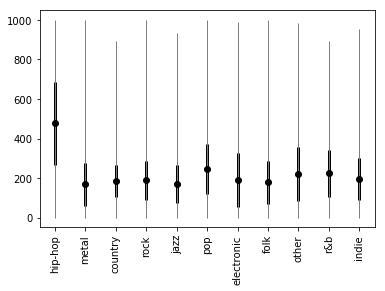

In [134]:
"""
Plot words in a song per genre.
"""
    
mins = []
maxes = []
means = []
std = []
for genre in plotted_genres:
    words_list = words_per_song_by_genre[genre]
    mins.append(min(words_list))
    maxes.append(max(words_list))
    mean = sum(words_list)/len(words_list)
    means.append(mean)
    std.append(np.std(words_list))
mins = np.array(mins)
maxes = np.array(maxes)
means = np.array(means)
std = np.array(std)

# create stacked errorbars:
plt.errorbar(np.arange(11), means, std, fmt='ok', lw=3)
plt.errorbar(np.arange(11), means, [means - mins, maxes - means],
            f fmt='.k', ecolor='gray', lw=1)
plt.xticks([x for x in range(11)], plotted_genres, rotation='vertical')

plt.show()

2500 lyrics finished..
5000 lyrics finished..
7500 lyrics finished..
10000 lyrics finished..
12500 lyrics finished..
15000 lyrics finished..
17500 lyrics finished..
20000 lyrics finished..
22500 lyrics finished..
25000 lyrics finished..
27500 lyrics finished..
30000 lyrics finished..
32500 lyrics finished..
35000 lyrics finished..
37500 lyrics finished..
40000 lyrics finished..
40466
Text preprocessing done.


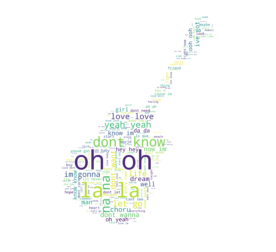

In [163]:
"""
Plot word cloud.
"""
# CHANGE THIS VAR TO MATCH THE CLOUD U WANT
target_genre = "pop"
text = ""
i = 0
for song_lyrics, genre in zip(lyrics, genres):
    if genre == target_genre:
        # lower case only
        song_lyrics = song_lyrics.lower()
        text += " " + song_lyrics 
        i += 1
        if i % 2500 == 0:
            print("%d lyrics finished.." % (i))
print(i)
            
print("Text preprocessing done.")

# remove punctuation
text = text.replace('(', '')
text = text.replace(')', '')
text = text.replace('\'', '')
text = text.replace('!', '')
text = text.replace('  ', ' ')

# remove stopwords
stopwords = set(STOPWORDS)
stopwords.add("said")

# make shape
base = getcwd()
guitar_mask = np.array(Image.open(path.join(base, "guitar.jpeg")))

wordcloud = WordCloud(width=3000, height=3000, scale=5, max_font_size=120, background_color="white", stopwords=stopwords, mask=guitar_mask).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# save to file
wordcloud.to_file(path.join(base, target_genre + ".png"))

In [61]:
"""
Plot balanced SVM vs balanced Logistic regressor.
"""

trace1 = go.Bar(
    x=plotted_genres,
    y=[ele[1] for ele in svm_stats],
    name='SVM'
)
trace2 = go.Bar(
    x=plotted_genres,
    y=[ele[1] for ele in log_regression_stats],
    name='Log Regresion'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Accuracy by Genre",
    barmode='group', 
    yaxis=dict(
        autotick=False,
        ticks='outside',
        tick0=0,
        dtick=0.1,
        ticklen=8,
        tickwidth=4,
        tickcolor='#000'
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~hle000/0 or inside your plot.ly account where it is named 'grouped-bar'


In [62]:
"""
Plot balanced SVM vs unbalanced SVM.
"""
trace1 = go.Bar(
    x=plotted_genres,
    y=[x[1] for x in svm_stats],
    name='SVM-Balanced'
)
trace2 = go.Bar(
    x=plotted_genres,
    y=[x[1] for x in svm_no_balance_stats],
    name='SVM-Unalanced', 
    marker=dict(
        color='rgb(235, 40, 40)'
    )
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Accuracy by Genre",
    barmode='group', 
    yaxis=dict(
        autotick=False,
        ticks='outside',
        tick0=0,
        dtick=0.1,
        ticklen=8,
        tickwidth=4,
        tickcolor='#000'
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~hle000/0 or inside your plot.ly account where it is named 'grouped-bar'


In [26]:
import gensim
w2v_model_path = './GoogleNews-vectors-negative300.bin'
model = gensim.models.KeyedVectors.load_word2vec_format(w2v_model_path, binary=True)

In [28]:
# TODO clean lyrics
print("calculating average vectors")
avg_w2v_vecs = []
count = 0
for d in df.values:
    if count % 50000 == 0: print(count)
    lyrics = d[5].split()
    vec = [model.word_vec(word) for word in lyrics if word in model.vocab]
    if len(vec) > 0: # FIXME should no vector = 0?
        vec = np.mean(vec, axis=0)
    else:
        vec = np.array([0]*300)
    avg_w2v_vecs.append(vec)
    count += 1
df['vecs'] = avg_w2v_vecs
print("done")
df.head()

calculating average vectors
0
50000
100000
150000
200000
done


,index,song,year,artist,genre,lyrics,vecs
0,187207,tear-down-these-walls,1988,billy-ocean,Pop,Tear down these walls Tear down these walls Te...,"[0.0619933, 0.0224841, 0.0841918, 0.114831, -0..."
1,74213,stitch,2007,discount,Pop,"left me on the edge, looking over. you said i ...","[0.0606513, 0.0192682, 0.0513763, 0.109383, -0..."
2,250943,typical,2004,the-daylights,Rock,Building her all upside down I outta know by n...,"[0.0502038, -0.0112331, 0.0437965, 0.0871379, ..."
3,129997,you-re-gonna-be-sorry,2006,dolly-parton,Country,Some day you're gonna want me but I ain't gonn...,"[0.0609542, 0.0458252, 0.0738555, 0.145147, -0..."
4,269081,life-begins-when-you-re-in-love,2006,billie-holiday,Jazz,Life begins when you're in love You have the w...,"[0.0485474, 0.0397153, 0.0688531, 0.109281, -0..."


In [29]:
# get vectors
genres, vectors = [], []
for x1, x2 in zip(df['vecs'], df['genre']):
    genres.append(x2.lower())
    vectors.append(x1)

# get number of total genres
total_genres = len(set(genres))
print("Num genres: %d" % (total_genres))

# create training and test set
training_x_vec = vectors[:len(vectors)//2]
training_y = genres[:len(vectors)//2]

test_x_vec = vectors[len(vectors)//2:]
test_y = genres[len(vectors)//2:]

Num genres: 11


In [81]:
# logistic regressor
classifier = Pipeline([
    ('clf', OneVsRestClassifier(LogisticRegression(class_weight='balanced')))])
classifier.fit(training_x_vec, training_y)
predictions = classifier.predict(test_x_vec)
# get accuracy
correct = 0
for label, prediction in zip(test_y, predictions):
    if label == prediction:
        correct += 1
print("Accuracy: %f" % (float(correct)/float(len(test_y))))

Accuracy: 0.321990


In [82]:
print("TRAINING METRICS")
test_metrics(classifier, training_y, training_x_vec, True)
print("TEST METRICS")
test_metrics(classifier, test_y, test_x_vec, True)

TRAINING METRICS
Top-1 Accuracy: 0.327846
Top-1 Balanced Accuracy: 0.360740
[('hip-hop', 0.7311366580310881),
 ('metal', 0.6782382113137766),
 ('country', 0.5311638168781025),
 ('jazz', 0.3526510480887793),
 ('folk', 0.32046678635547576),
 ('r&b', 0.309662398137369),
 ('indie', 0.29251269035532995),
 ('pop', 0.2081447963800905),
 ('rock', 0.19581909695433336),
 ('electronic', 0.17500628614533567),
 ('other', 0.17334360554699538)]
Top-2 Accuracy: 0.513103
Top-2 Balanced Accuracy: 0.526997
[('hip-hop', 0.7743685233160622),
 ('metal', 0.7484239724300243),
 ('country', 0.6733314947600662),
 ('jazz', 0.5329223181257706),
 ('r&b', 0.5168800931315483),
 ('folk', 0.4991023339317774),
 ('indie', 0.48984771573604063),
 ('pop', 0.43365138697619515),
 ('rock', 0.4293324515963114),
 ('electronic', 0.36937389992456626),
 ('other', 0.32973805855161786)]
Top-3 Accuracy: 0.648363
Top-3 Balanced Accuracy: 0.645947
[('hip-hop', 0.8099902849740933),
 ('metal', 0.7881818945952761),
 ('country', 0.750413678

In [83]:
# logistic regressor
classifier = Pipeline([
    ('clf', OneVsRestClassifier(RandomForestClassifier()))])
classifier.fit(training_x_vec, training_y)
predictions = classifier.predict(test_x_vec)
# get accuracy
correct = 0
for label, prediction in zip(test_y, predictions):
    if label == prediction:
        correct += 1
print("Accuracy: %f" % (float(correct)/float(len(test_y))))

Accuracy: 0.548620


In [84]:
print("TRAINING METRICS")
test_metrics(classifier, training_y, training_x_vec, True)
print("TEST METRICS")
test_metrics(classifier, test_y, test_x_vec, True)

TRAINING METRICS
Top-1 Accuracy: 0.979457
Top-1 Balanced Accuracy: 0.953976
[('rock', 0.9969506594658143),
 ('hip-hop', 0.9887467616580311),
 ('pop', 0.9790969899665551),
 ('country', 0.9735245449531164),
 ('indie', 0.9638324873096447),
 ('metal', 0.9523409262839371),
 ('r&b', 0.9481955762514552),
 ('electronic', 0.9308524013075182),
 ('jazz', 0.930209617755857),
 ('other', 0.926040061633282),
 ('folk', 0.9039497307001796)]
Top-2 Accuracy: 0.994642
Top-2 Balanced Accuracy: 0.983377
[('rock', 0.999467283882582),
 ('hip-hop', 0.9961949481865285),
 ('pop', 0.9950324611449931),
 ('country', 0.9939327082184225),
 ('metal', 0.9936118349163655),
 ('other', 0.9895993836671803),
 ('r&b', 0.9871944121071012),
 ('indie', 0.9841370558375635),
 ('jazz', 0.9755856966707768),
 ('electronic', 0.9751068644707066),
 ('folk', 0.9272890484739676)]
Top-3 Accuracy: 0.996760
Top-3 Balanced Accuracy: 0.988443
[('rock', 0.9998714133509681),
 ('metal', 0.9968059174581827),
 ('hip-hop', 0.9963568652849741),
 ('p

/Users/jimmy/miniconda3/envs/jupyter/lib/python3.6/site-packages/sklearn/multiclass.py:352: RuntimeWarning:

invalid value encountered in true_divide



Top-1 Accuracy: 0.548620
Top-1 Balanced Accuracy: 0.232092
[('rock', 0.8829315473474826),
 ('hip-hop', 0.5860137622019523),
 ('metal', 0.3498566852132861),
 ('pop', 0.24406476606734875),
 ('jazz', 0.1310344827586207),
 ('electronic', 0.08398094760591628),
 ('country', 0.08381219341275403),
 ('r&b', 0.061200237670825906),
 ('folk', 0.05225863596102746),
 ('other', 0.05052063247204011),
 ('indie', 0.02733630006357279)]
Top-2 Accuracy: 0.731807
Top-2 Balanced Accuracy: 0.369630
[('rock', 0.9736846907677428),
 ('hip-hop', 0.7336373819811169),
 ('pop', 0.7251912188338134),
 ('metal', 0.6453380542910133),
 ('country', 0.27302032235459006),
 ('jazz', 0.2066411238825032),
 ('electronic', 0.14013537227375283),
 ('r&b', 0.12834224598930483),
 ('other', 0.11839568067875048),
 ('folk', 0.08148804251550044),
 ('indie', 0.040050858232676415)]
Top-3 Accuracy: 0.805792
Top-3 Balanced Accuracy: 0.472777
[('rock', 0.9903644360092706),
 ('pop', 0.8583987285189232),
 ('hip-hop', 0.8153304528724596),
 ('me

In [39]:
performance_by_genre(test_y, predictions)
# Top-N accuracy
predict_probs = classifier.predict_proba(test_x_vec)
n = 2
top_ns = []
for pp in predict_probs:
    prob_cat = zip(pp, classifier.classes_)
    top_ns.append([cat for prob, cat in sorted(prob_cat)[-n:]])
    
top_n_correct = 0
for label, top_n in zip(test_y, top_ns):
    if label in top_n:
        top_n_correct += 1
print("Top-%d Accuracy: %f" % (n, float(top_n_correct)/float(len(test_y))))

[('rock', 0.8792999616767341),
 ('hip-hop', 0.5872939670347256),
 ('metal', 0.3464002697690103),
 ('pop', 0.24615078970895005),
 ('jazz', 0.13128991060025544),
 ('country', 0.09053959355290819),
 ('electronic', 0.07996991727249937),
 ('r&b', 0.061200237670825906),
 ('other', 0.051291939838025456),
 ('folk', 0.050487156775907885),
 ('indie', 0.029879211697393517)]
Balanced Accuracy = 0.23216390505429418


/Users/jimmy/miniconda3/envs/jupyter/lib/python3.6/site-packages/sklearn/multiclass.py:352: RuntimeWarning:

invalid value encountered in true_divide



Top-2 Accuracy: 0.730850


In [86]:
# svm classifier without class balance
classifier = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english', analyzer='word')),
    #('tfidf', TfidfTransformer()),
    #('GNB', GaussianNB())
    ('MNB', MultinomialNB(alpha=1))
    #('BNB', BernoulliNB())
])
classifier.fit(training_x, training_y)
predictions = classifier.predict(test_x)
# get accuracy
correct = 0
for label, prediction in zip(test_y, predictions):
    if label == prediction:
        correct += 1
print("Accuracy: %f" % (float(correct)/float(len(test_y))))
performance_by_genre(test_y, predictions)

Accuracy: 0.553879
[('rock', 0.798638611602825),
 ('hip-hop', 0.7497199551928309),
 ('metal', 0.595852301466869),
 ('country', 0.23433777154870358),
 ('pop', 0.22126750769842057),
 ('other', 0.14731970690320093),
 ('folk', 0.09211691762621789),
 ('jazz', 0.06181353767560664),
 ('electronic', 0.031336174479819505),
 ('r&b', 0.0041592394533571005),
 ('indie', 0.0012714558169103624)]
Balanced Accuracy = 0.2670757435877056


In [87]:
print("TRAINING METRICS")
test_metrics(classifier, training_y, training_x, True)
print("TEST METRICS")
test_metrics(classifier, test_y, test_x, True)

TRAINING METRICS
Top-1 Accuracy: 0.595126
Top-1 Balanced Accuracy: 0.322208
[('rock', 0.8288144310959257),
 ('hip-hop', 0.7701586787564767),
 ('metal', 0.6507522904934017),
 ('country', 0.333011583011583),
 ('pop', 0.2747393271689947),
 ('other', 0.23266563944530047),
 ('folk', 0.1741472172351885),
 ('jazz', 0.12231812577065351),
 ('electronic', 0.1134020618556701),
 ('r&b', 0.02270081490104773),
 ('indie', 0.021573604060913704)]
Top-2 Accuracy: 0.787119
Top-2 Balanced Accuracy: 0.464503
[('rock', 0.9478672985781991),
 ('metal', 0.8499621753383206),
 ('hip-hop', 0.8299060880829016),
 ('pop', 0.7534920322644107),
 ('country', 0.7506894649751793),
 ('other', 0.27426810477657937),
 ('jazz', 0.2369913686806412),
 ('folk', 0.20556552962298025),
 ('electronic', 0.18229821473472466),
 ('indie', 0.041243654822335024),
 ('r&b', 0.037252619324796274)]
Top-3 Accuracy: 0.870749
Top-3 Balanced Accuracy: 0.554605
[('rock', 0.9790036371652154),
 ('country', 0.9613899613899614),
 ('pop', 0.94112728703

In [210]:
count_vecs = CountVectorizer(stop_words='english', analyzer='word').fit_transform(training_x)
avg_len = np.mean([scipy.sparse.linalg.norm(v) for v in count_vecs])
print("avg_len = {}".format(avg_len))

avg_len = 19.431519152710283


In [20]:
#avg_count = np.mean([len(x.split()) for x in training_x])
def scale_func(X):
    #pprint.pprint("HELLO")
    return X * avg_len
"""
def scale_func(X, y=None):
    #pprint.pprint("HELLO")
    if y is not None:
        print("NOT NONE")
    else:
        print("NONE")
    raise Exception('My error!')
    return X * avg_len"""

def print_func(X):
    print(np.linalg.norm(X))
    return X

In [88]:
# multinomial naive-bayes
classifier = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english', analyzer='word')),
    ('tfidf', TfidfTransformer()),
    #('normalize', Normalizer()),
    #('scale', FunctionTransformer(func=scale_func, validate=False)),
    #('GNB', GaussianNB())
    ('MNB', MultinomialNB(alpha=1.0e-10))
    #('BNB', BernoulliNB())
])
classifier.fit(training_x, training_y)
predictions = classifier.predict(test_x)
# get accuracy
correct = 0
for label, prediction in zip(test_y, predictions):
    if label == prediction:
        correct += 1
print("Accuracy: %f" % (float(correct)/float(len(test_y))))
performance_by_genre(test_y, predictions)

Accuracy: 0.572658
[('rock', 0.8676387393470445),
 ('hip-hop', 0.7754040646503441),
 ('metal', 0.46155791603439555),
 ('pop', 0.20929770537399423),
 ('country', 0.1829011913104415),
 ('jazz', 0.1591315453384419),
 ('folk', 0.1054030115146147),
 ('other', 0.08908600077130736),
 ('electronic', 0.04537478064677864),
 ('r&b', 0.036244800950683304),
 ('indie', 0.015257469802924348)]
Balanced Accuracy = 0.26793611143099727


In [90]:
print("TRAINING METRICS")
test_metrics(classifier, training_y, training_x, True)
print("TEST METRICS")
test_metrics(classifier, test_y, test_x, True)

TRAINING METRICS
Top-1 Accuracy: 0.739842
Top-1 Balanced Accuracy: 0.527463
[('rock', 0.9679268158271795),
 ('hip-hop', 0.8698996113989638),
 ('metal', 0.7147179961334791),
 ('folk', 0.49281867145421904),
 ('country', 0.4674572531715389),
 ('jazz', 0.4404438964241677),
 ('pop', 0.41820775132795596),
 ('other', 0.4140986132511556),
 ('electronic', 0.3583102841337692),
 ('indie', 0.35786802030456855),
 ('r&b', 0.30034924330616997)]
Top-2 Accuracy: 0.902611
Top-2 Balanced Accuracy: 0.721562
[('rock', 0.9981446783496822),
 ('hip-hop', 0.914264896373057),
 ('metal', 0.9109859628477768),
 ('pop', 0.907584103875664),
 ('country', 0.8367346938775511),
 ('jazz', 0.6394574599260172),
 ('folk', 0.599640933572711),
 ('indie', 0.5831218274111675),
 ('other', 0.5458397534668721),
 ('electronic', 0.5252703042494342),
 ('r&b', 0.47613504074505236)]
Top-3 Accuracy: 0.952946
Top-3 Balanced Accuracy: 0.834527
[('rock', 0.9995775010103237),
 ('pop', 0.9851465669879992),
 ('country', 0.9771097628240485),
 

In [11]:
from sklearn.utils.class_weight import compute_class_weight
categories = np.array(list(set(training_y)))
print(categories)
class_weights = compute_class_weight('balanced', categories, training_y)
print(class_weights)

['electronic' 'country' 'hip-hop' 'pop' 'metal' 'indie' 'r&b' 'other'
 'rock' 'folk' 'jazz']
[ 2.7189125   1.52109091  0.89555864  0.54631473  0.92648148  7.1193732
  6.37451393  4.2893462   0.20172881  9.67360447  2.79825148]


In [91]:
# svm classifier without class balance
classifier = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english', analyzer='word')),
    ('tfidf', TfidfTransformer()),
    #('normalize', Normalizer()),
    #('scale', FunctionTransformer(func=scale_func, validate=False)),
    #('GNB', GaussianNB())
    ('MNB', MultinomialNB(alpha=1))
    #('BNB', BernoulliNB())
])
classifier.fit(training_x, training_y)
predictions = classifier.predict(test_x)
# get accuracy
correct = 0
for label, prediction in zip(test_y, predictions):
    if label == prediction:
        correct += 1
print("Accuracy: %f" % (float(correct)/float(len(test_y))))
performance_by_genre(test_y, predictions)

Accuracy: 0.500725
[('rock', 0.9662207785097724),
 ('hip-hop', 0.3785405664906385),
 ('pop', 0.12401907221615179),
 ('metal', 0.04628224582701062),
 ('folk', 0.010628875110717449),
 ('electronic', 0.0017548257708698922),
 ('indie', 0.0),
 ('jazz', 0.0),
 ('other', 0.0),
 ('r&b', 0.0),
 ('country', 0.0)]
Balanced Accuracy = 0.13885876035683278


In [ ]:
print("TRAINING METRICS")
test_metrics(classifier, training_y, training_x, True)
print("TEST METRICS")
test_metrics(classifier, test_y, test_x, True)

TRAINING METRICS
Top-1 Accuracy: 0.504052
Top-1 Balanced Accuracy: 0.146727
[('rock', 0.967155295932988),
 ('hip-hop', 0.39985427461139894),
 ('pop', 0.13043478260869565),
 ('metal', 0.07018576111624779),
 ('folk', 0.03680430879712747),
 ('other', 0.0061633281972265025),
 ('electronic', 0.0027659039476992707),
 ('indie', 0.0006345177664974619),
 ('country', 0.0),
 ('jazz', 0.0),
 ('r&b', 0.0)]
Top-2 Accuracy: 0.749660
Top-2 Balanced Accuracy: 0.313811
[('rock', 0.9988243506374224),
 ('pop', 0.9397009639976391),
 ('hip-hop', 0.7844883419689119),
 ('metal', 0.6316718500462302),
 ('folk', 0.04578096947935368),
 ('other', 0.028120184899845916),
 ('country', 0.011720904578047435),
 ('electronic', 0.006537591149107368),
 ('jazz', 0.0044389642416769425),
 ('indie', 0.0006345177664974619),
 ('r&b', 0.0)]
Top-3 Accuracy: 0.822912
Top-3 Balanced Accuracy: 0.395395
[('pop', 0.9997540822349007),
 ('rock', 0.9996142400529042),
 ('hip-hop', 0.9670498704663213),
 ('metal', 0.8613936286458771),
 ('cou

In [10]:
# svm classifier without class balance
classifier = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english', analyzer='word')),
    #('tfidf', TfidfTransformer()),
    #('normalize', Normalizer()),
    #('scale', FunctionTransformer(func=scale_func, validate=False)),
    #('GNB', GaussianNB())
    #('MNB', MultinomialNB(alpha=1, fit_prior=True))
    ('CNB', ComplementNB())
    #('BNB', BernoulliNB())
])
classifier.fit(training_x, training_y)
predictions = classifier.predict(test_x)
# get accuracy
correct = 0
for label, prediction in zip(test_y, predictions):
    if label == prediction:
        correct += 1
print("Accuracy: %f" % (float(correct)/float(len(test_y))))
performance_by_genre(test_y, predictions)

NameError: name 'ComplementNB' is not defined